In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import json
import numpy as np

from datetime import datetime, timedelta
import pytz

from pathlib import Path
from math import isnan

import matplotlib.ticker as plticker
import seaborn as sns

sns.set_style("whitegrid")
pd.set_option("display.precision", 4)

# show all columns by default
pd.set_option('display.max_columns', None)

In [1]:
!wget https://www.dropbox.com/s/pfsiodhtzetxbl0/ltc-all-the-states-2021-05-26.zip?dl=1 -O ltc.zip

--2021-05-26 14:19:06--  https://www.dropbox.com/s/pfsiodhtzetxbl0/ltc-all-the-states-2021-05-26.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/pfsiodhtzetxbl0/ltc-all-the-states-2021-05-26.zip [following]
--2021-05-26 14:19:06--  https://www.dropbox.com/s/dl/pfsiodhtzetxbl0/ltc-all-the-states-2021-05-26.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc695134ec738d68f33af3d8d0e5.dl.dropboxusercontent.com/cd/0/get/BPOhgx3XN6DOuT-kj8NjBSU9fzj8qmMVLEqK08OI3FwgScyhDH4P528YS80NR4zSjfkygFNFn5Pcuqrmkl4VkkIbWxwsyPo1A-w3tGMfoktKn-l1mOy8g9qAkKCPPwBQlRtANuKRrj9UAKm_eG-UZkbP/file?dl=1# [following]
--2021-05-26 14:19:07--  https://uc695134ec738d68f33af3d8d0e5.dl.dropboxusercontent.com/cd/0/get/BPOhgx3XN6DOuT-kj8NjBSU9fzj8qmMVLEqK08OI3FwgScyhDH4P5

In [2]:
!unzip ltc.zip

Archive:  ltc.zip
   creating: ltc-all-the-states/
  inflating: ltc-all-the-states/ltc-overview-VT.html  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-HI.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-SC.csv  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-GA.csv  
  inflating: ltc-all-the-states/ltc-overview-SC.html  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-DC.csv  
  inflating: ltc-all-the-states/ltc-allstates-cumulative_resident_deaths_vs_cms_nursing_home_data-2021-05-26.html  
  inflating: ltc-all-the-states/csvexport-ltc-overview-KY.csv  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-CO.csv  
  inflating: ltc-all-the-states/ltc-overview-MS.html  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-ME.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-NV.csv  
  inflating: ltc-all-the-states/ltc-overview-TN.html  
  inflating: ltc-all-the-states/ltc-overview-HI.html  
  inflating: ltc-all-the-s

  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-TN.csv  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-LA.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-CT.csv  
  inflating: ltc-all-the-states/ltc-overview-IA.html  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-KY.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-KS.csv  
  inflating: ltc-all-the-states/ltc-allstates-cumulative_resident_deaths-2021-05-26.html  
  inflating: ltc-all-the-states/csvexport-ltc-overview-TN.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-NM.csv  
  inflating: ltc-all-the-states/csvexport-ltc-overview-DC.csv  
  inflating: ltc-all-the-states/ltc-allstates-facilities_reporting_vs_cms_nursing_home_data-2021-05-26.html  
  inflating: ltc-all-the-states/ltc-overview-CT.html  
  inflating: ltc-all-the-states/ltc-overview-FL.html  
  inflating: ltc-all-the-states/csvexport-ltc-ctpcmsmerged-MS.csv  
  inflating: ltc-all-the-states/csvexport-

# Load CTP data

In [127]:
ctp_df = pd.read_csv('ltc-all-the-states/csvexport-ltc-allstates.csv').drop_duplicates()
ctp_df.head()

/Users/julia/miniconda3/envs/deep-learning-nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4,5,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ctp_facility,ctp_ctp_id,ctp_state_facility_type,ctp_ctp_facility_type,ctp_cms_id,ctp_city,ctp_county,ctp_cms_week,ctp_cume_res_death,ctp_cume_res_probdeath,ctp_cume_res_pos,ctp_cume_res_probpos,ctp_outbrk_status,ctp_outbrk_res_death,ctp_outbrk_res_probdeath,ctp_outbrk_res_pos,ctp_outbrk_res_probpos,ctp_outbrk_resstaff_death,ctp_outbrk_resstaff_probdeath,ctp_outbrk_resstaff_pos,ctp_outbrk_resstaff_probpos,ctp_cume_resstaff_pos,ctp_cume_resstaff_probpos,ctp_cume_resstaff_death,ctp_cume_resstaff_probdeath,ctp_cume_staff_pos,ctp_cume_staff_probpos,ctp_cume_staff_death,ctp_cume_staff_probdeath,order,ctp_state
0,ALLAY HEALTH AND REHAB,AR00004,UNCATEGORIZED LTC,Nursing Home,45288,LITTLE ROCK,PULASKI,2020-05-24,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,0,AR
1,AMBERWOOD HEALTH & REHAB,AR00008,UNCATEGORIZED LTC,Nursing Home,45464,BENTON,SALINE,2020-05-24,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0,AR
2,APPLE CREEK HEALTH & REHABILITATION,AR00010,UNCATEGORIZED LTC,Nursing Home,45465,CENTERTON,BENTON,2020-05-24,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,AR
3,ASH FLAT HEALTHCARE AND REHABILITATION CENTER,AR00022,UNCATEGORIZED LTC,Nursing Home,45155,ASH FLAT,SHARP,2020-05-24,2.0,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,0,AR
4,BELLE VIEW ESTATES REHABILITATION & CARE CENTER,AR00035,UNCATEGORIZED LTC,Nursing Home,45239,MONTICELLO,DREW,2020-05-24,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,AR


In [129]:
# annotate CTP data

def annotate_ctp_df(ctp_df):
  # cases
  ctp_resident_case_cols = ['ctp_cume_res_pos', 'ctp_cume_res_probpos']
  ctp_staff_case_cols = ['ctp_cume_staff_pos', 'ctp_cume_staff_probpos']
  ctp_resstaff_case_cols = ['ctp_cume_resstaff_pos', 'ctp_cume_resstaff_probpos']

  # deaths
  ctp_resident_death_cols = ['ctp_cume_res_death', 'ctp_cume_res_probdeath']
  ctp_staff_death_cols = ['ctp_cume_staff_death', 'ctp_cume_staff_probdeath']
  ctp_resstaff_death_cols = ['ctp_cume_resstaff_death', 'ctp_cume_resstaff_probdeath']

  # total case columns
  ctp_df['ctp_resident_total_cases'] = ctp_df[ctp_resident_case_cols].sum(axis=1)
  ctp_df['ctp_staff_total_cases'] = ctp_df[ctp_staff_case_cols].sum(axis=1)
  ctp_df['ctp_resstaff_total_cases'] = ctp_df[ctp_resstaff_case_cols].sum(axis=1)

  # total death columns
  ctp_df['ctp_resident_total_deaths'] = ctp_df[ctp_resident_death_cols].sum(axis=1)
  ctp_df['ctp_resident_and_resstaff_total_deaths'] = ctp_df[
    ctp_resident_death_cols + ctp_resstaff_death_cols].sum(axis=1)
  ctp_df['ctp_staff_total_deaths'] = ctp_df[ctp_staff_death_cols].sum(axis=1)
  ctp_df['ctp_resstaff_total_deaths'] = ctp_df[ctp_resstaff_death_cols].sum(axis=1)

print(ctp_df.shape)
annotate_ctp_df(ctp_df)
print(ctp_df.shape)

(759522, 36)
(759522, 38)


# Load CMS data

In [4]:
# download CMS: doing this offline
# !wget -O cms.csv https://data.cms.gov/api/views/s2uc-8wxp/rows.csv?accessType=DOWNLOAD&api_foundry=true

In [7]:
cms_df = pd.read_csv('cms.csv')
print(cms_df.shape)

# clean up the cms df column names (copied from Dave's initial notebook)
cms_df['week'] = pd.to_datetime(cms_df['Week Ending'])
cms_df.sort_values(['Provider State','Federal Provider Number','week'], ascending=True, inplace=True)
cms_df = cms_df.reset_index().drop('index', axis=1)
cms_df.columns = ['cms_'+i.lower().strip().replace(' ','_').replace('/','_').replace('-','_') for i in cms_df.columns]
cms_df['cms_federal_provider_number'] = cms_df['cms_federal_provider_number'].apply(lambda x: str(x).lstrip('0').split('.')[0])

# convert cms_week to cms_week_str to match the CTP data types
cms_df['cms_week'] = cms_df.cms_week.apply(lambda x: x.strftime('%Y-%m-%d'))

/Users/julia/miniconda3/envs/deep-learning-nlp/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1,82,83) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(782376, 138)


In [8]:
slim_cms_df = cms_df[(cms_df['cms_week']>'2020-05-24')][
                        ['cms_week','cms_federal_provider_number',
                        'cms_provider_name',
                        'cms_provider_state',
                        'cms_residents_weekly_confirmed_covid_19',
                        'cms_residents_total_confirmed_covid_19',
                        'cms_residents_weekly_suspected_covid_19',
                        'cms_residents_total_suspected_covid_19',
                        'cms_residents_weekly_covid_19_deaths',
                        'cms_residents_total_covid_19_deaths',
                        'cms_residents_weekly_all_deaths',
                        'cms_residents_total_all_deaths',
                        'cms_staff_weekly_confirmed_covid_19',
                        'cms_staff_total_confirmed_covid_19',
                        'cms_staff_weekly_suspected_covid_19',
                        'cms_staff_total_suspected_covid_19',
                        'cms_staff_weekly_covid_19_deaths',
                        'cms_staff_total_covid_19_deaths',
                        # 'cms_number_of_all_beds',
                        # 'cms_total_number_of_occupied_beds',
                      ]]

In [9]:
slim_cms_df.shape

(767008, 18)

In [10]:
# annotate CMS data
def annotate_cms_df(cms_df):
    # resident and staff case columns
    cms_resident_case_cols = ['cms_residents_total_confirmed_covid_19', 'cms_residents_total_suspected_covid_19']
    cms_staff_case_cols = ['cms_staff_total_confirmed_covid_19', 'cms_staff_total_suspected_covid_19']

    # total case columns
    cms_df['cms_resident_total_cases'] = cms_df[cms_resident_case_cols].sum(axis=1)
    cms_df['cms_staff_total_cases'] = cms_df[cms_staff_case_cols].sum(axis=1)

annotate_cms_df(slim_cms_df)
slim_cms_df.shape

(767008, 20)

# Merge CTP and CMS data

In [130]:
cms_ctp_merged = pd.merge(slim_cms_df, ctp_df, how='inner', left_on=['cms_week','cms_federal_provider_number'], right_on=['ctp_cms_week','ctp_cms_id'])
cms_ctp_merged_outer = pd.merge(slim_cms_df, ctp_df, how='outer', left_on=['cms_week','cms_federal_provider_number'], right_on=['ctp_cms_week','ctp_cms_id'])
print('Inner merged shape: %s' % str(cms_ctp_merged.shape))
print('Outer merged shape: %s' % str(cms_ctp_merged_outer.shape))
print('CMS shape: %s' % str(slim_cms_df.shape))
print('CTP shape: %s' % str(ctp_df.shape))

Inner merged shape: (289533, 58)
Outer merged shape: (1245086, 58)
CMS shape: (767008, 20)
CTP shape: (759522, 38)


In [131]:
def annotate_cms_ctp_merged_df(cms_ctp_merged):
  # case difference columns
  cms_ctp_merged['cms_ctp_resident_cases_diff'] = \
    cms_ctp_merged['cms_resident_total_cases'] - cms_ctp_merged['ctp_resident_total_cases']
  cms_ctp_merged['cms_ctp_staff_cases_diff'] = \
    cms_ctp_merged['cms_staff_total_cases'] - cms_ctp_merged['ctp_staff_total_cases']

  # deaths difference columns
  cms_ctp_merged['cms_ctp_resident_deaths_diff'] = \
    cms_ctp_merged['cms_residents_total_covid_19_deaths'] - cms_ctp_merged['ctp_resident_total_deaths']
  cms_ctp_merged['cms_ctp_staff_deaths_diff'] = \
    cms_ctp_merged['cms_staff_total_covid_19_deaths'] - cms_ctp_merged['ctp_staff_total_deaths']
  cms_ctp_merged['cms_ctp_resident_and_resstaff_deaths_diff'] = \
    cms_ctp_merged['cms_residents_total_covid_19_deaths'] - cms_ctp_merged['ctp_resident_and_resstaff_total_deaths']

  # for each "diff" col, compute its absolute value
  diff_cols = [x for x in cms_ctp_merged.columns if x.endswith('_diff')]
  for diff_col in diff_cols:
    cms_ctp_merged[diff_col + '_abs'] = cms_ctp_merged[diff_col].abs()

annotate_cms_ctp_merged_df(cms_ctp_merged)
cms_ctp_merged.shape

(289533, 68)

# Some constants

In [132]:
LATEST_DATE = cms_ctp_merged.ctp_cms_week.max()
print(LATEST_DATE)

2021-03-07


# Actual analysis bits

In [133]:
def plot_facilities_barchart(cms_ctp_merged, state, diffs_to_plot, use_date='latest'):
  # create the necessary data, save a file describing matching problems for the latest date
  state_cms_ctp_merged_df = cms_ctp_merged.loc[cms_ctp_merged.ctp_state == state].copy()

  for (abs_diff_cutoff, y_axis) in diffs_to_plot:
    abs_column = y_axis + '_abs'
    title = '%s %s: CMS minus CTP (min diff cutoff: %d)' % (state, y_axis[8:].replace('_', ' '), abs_diff_cutoff)

    # plot away and save results
    plt.figure(figsize=(18,7))

    def get_color(row):
        if row[y_axis] > 0:
            return '#ffad4a'  # orange
        else:
            return '#585bc1'  # purple

    # grab everything as of the given date
    if use_date == 'latest':
      use_date = state_cms_ctp_merged_df.cms_week.max()
    state_cms_ctp_merged_df_most_recent_date = state_cms_ctp_merged_df.loc[
        (state_cms_ctp_merged_df.cms_week == use_date)]

    high_diffs_df = state_cms_ctp_merged_df_most_recent_date.loc[
      state_cms_ctp_merged_df_most_recent_date[abs_column] > abs_diff_cutoff].sort_values(by=[y_axis]).reset_index()
    data = high_diffs_df
    if data.empty:
      print('No data passing the input filters')
      return
    palette = list(data.apply(get_color, axis=1))

    ax = sns.barplot(x=data.index, y=y_axis, data=data, palette=palette)
    sns.despine(ax=ax, left=True)
    ax.set_xticklabels(rotation=90, labels=data.ctp_facility, fontsize=10)
    ax.set_yticklabels(ax.get_yticks(), size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title, size=20)
    return high_diffs_df

In [134]:
# state = 'AR'

# # each item in the tuple is: (the minimum abs diff to include a facility in the plot, column whose values we're plotting)
# diffs_to_plot = (
#     [15, 'cms_ctp_resident_deaths_diff'],
# )

# high_diffs = plot_facilities_barchart(cms_ctp_merged, state, diffs_to_plot)

In [135]:
# what are the most divergent rows in the most recent data, for a particular state and diff column?
state = 'CT'
diff_column = 'cms_ctp_resident_deaths_diff'
abs_diff_cutoff = 15

def get_facility_data(cms_ctp_merged_outer, facility_name, state):
    data = cms_ctp_merged_outer.loc[(cms_ctp_merged_outer.ctp_facility == facility_name) & (cms_ctp_merged_outer.ctp_state == state)].sort_values(by=['ctp_cms_week'])
    data = data[data['ctp_cms_week'].notna()]
    return data

# same thing but for the outer merged bit so we can see what happened before that
def plot_facility_over_time(state, facility_name, ax=None):
    data = get_facility_data(cms_ctp_merged_outer, facility_name, state)
    if ax is None:
        ax = sns.lineplot(x='ctp_cms_week', y='ctp_resident_total_deaths', data=data, color='orange')  # CTP is orange
    else:
        sns.lineplot(x='ctp_cms_week', y='ctp_resident_total_deaths', ax=ax, data=data, color='orange')  # CTP is orange
    sns.lineplot(x='ctp_cms_week', y='cms_residents_total_covid_19_deaths', data=data, ax=ax, color='blue')  # CMS is blue
    ax.set_ylabel('Cumulative deaths')
    loc = plticker.MultipleLocator(base=11.0) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    ax.set_title(facility_name)

# Are there states that reported way more NH deaths the last week of May/first 2 weeks of June than CMS?
# If you track specific facilities that were reporting more deaths in those first 3 weeks, do those discrepancies persist?

## Looking at CT first: which facilities drive discrepancy in counts?

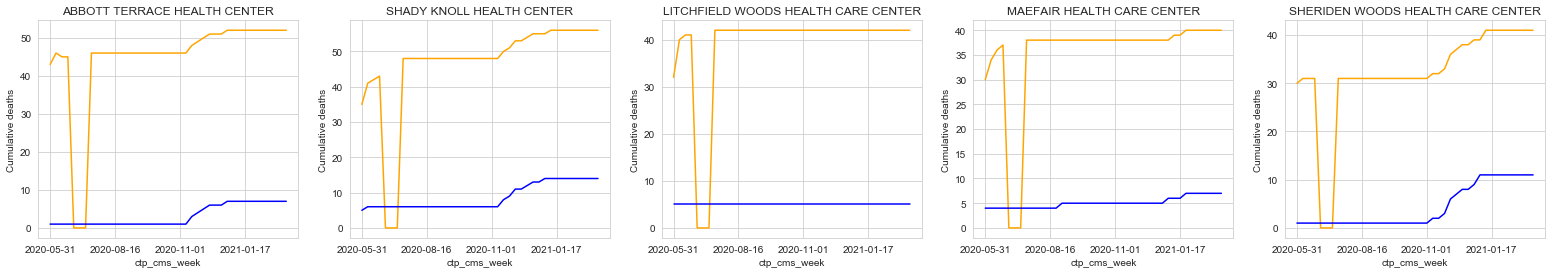

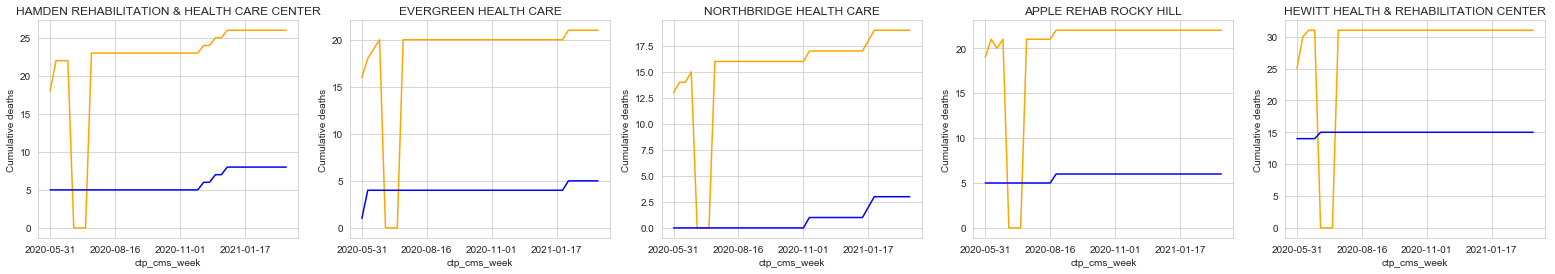

In [136]:
# what are the most divergent rows in the most recent data, for a particular state and diff column?
state = 'CT'
diff_column = 'cms_ctp_resident_deaths_diff'
abs_diff_cutoff = 15

latest_state_data = cms_ctp_merged.loc[
    (cms_ctp_merged.ctp_state == state) &
    (cms_ctp_merged.ctp_cms_week == LATEST_DATE)]

# throw out any CMS IDs that occur more than once (questionable matching)
dupes = latest_state_data.cms_federal_provider_number.duplicated(keep=False)
latest_state_data = latest_state_data[~dupes]

abs_column = diff_column + '_abs'
sorted_data = latest_state_data.loc[
  latest_state_data[abs_column] > abs_diff_cutoff].sort_values(by=[diff_column]).reset_index()
highest_ctp = list(sorted_data[:5].ctp_facility)
lowest_ctp = list(sorted_data[-5:].ctp_facility)

fig, axes = plt.subplots(1, 5, figsize=(27, 4))
for i, facility_name in enumerate(highest_ctp):
    plot_facility_over_time(state, facility_name, ax=axes[i])

fig, axes = plt.subplots(1, 5, figsize=(27, 4))
for i, facility_name in enumerate(lowest_ctp):
    plot_facility_over_time(state, facility_name, ax=axes[i])

## AR: which facilities drive discrepancy in counts?

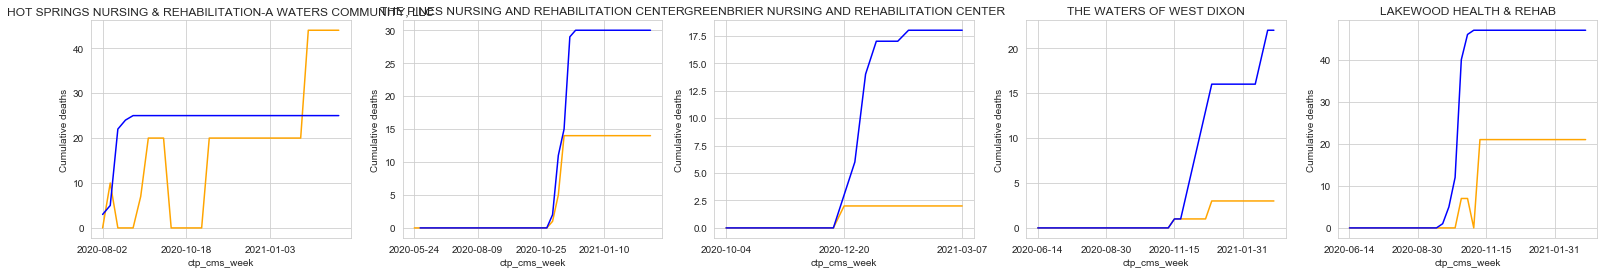

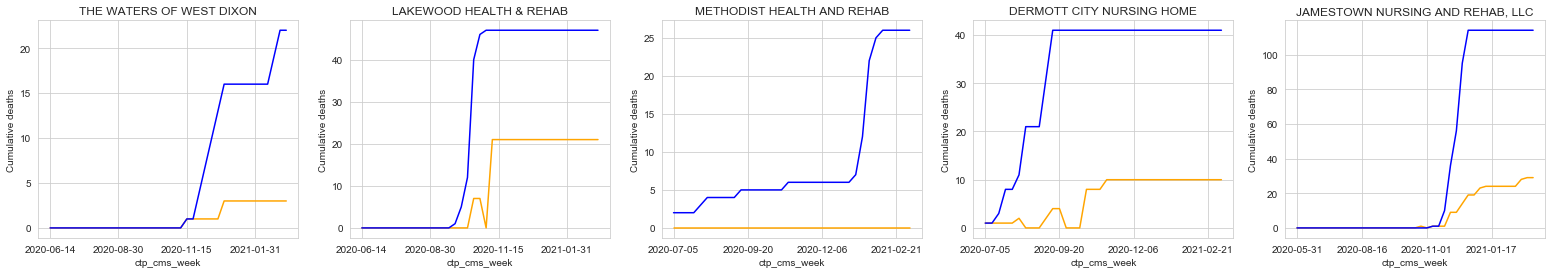

In [137]:
# what are the most divergent rows in the most recent data, for a particular state and diff column?
state = 'AR'
diff_column = 'cms_ctp_resident_deaths_diff'
abs_diff_cutoff = 15

latest_state_data = cms_ctp_merged.loc[
    (cms_ctp_merged.ctp_state == state) &
    (cms_ctp_merged.ctp_cms_week == LATEST_DATE)]

# throw out any CMS IDs that occur more than once (questionable matching)
dupes = latest_state_data.cms_federal_provider_number.duplicated(keep=False)
latest_state_data = latest_state_data[~dupes]

abs_column = diff_column + '_abs'
sorted_data = latest_state_data.loc[
  latest_state_data[abs_column] > abs_diff_cutoff].sort_values(by=[diff_column]).reset_index()
highest_ctp = list(sorted_data[:5].ctp_facility)
lowest_ctp = list(sorted_data[-5:].ctp_facility)

fig, axes = plt.subplots(1, 5, figsize=(27, 4))
for i, facility_name in enumerate(highest_ctp):
    plot_facility_over_time(state, facility_name, ax=axes[i])

fig, axes = plt.subplots(1, 5, figsize=(27, 4))
for i, facility_name in enumerate(lowest_ctp):
    plot_facility_over_time(state, facility_name, ax=axes[i])

In [142]:
latest_state_data_outer = cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.ctp_state == 'AR') &
    ((cms_ctp_merged_outer.ctp_cms_week == LATEST_DATE) | (cms_ctp_merged_outer.cms_week == LATEST_DATE))]
latest_state_data_outer.shape

(314, 58)

In [139]:
latest_state_data_outer.ctp_ctp_facility_type.value_counts()

Nursing Home     220
Uncategorized     94
Name: ctp_ctp_facility_type, dtype: int64

In [140]:
latest_state_data.ctp_resident_total_deaths.sum()

1763.0

In [141]:
latest_state_data_outer.ctp_resident_total_deaths.sum()

1886.0

In [143]:
# in CTP data: total reported resident deaths
ctp_df.loc[
    (ctp_df.ctp_state == 'AR') &
    (ctp_df.ctp_cms_week == LATEST_DATE)
].ctp_resident_total_deaths.sum()

1886.0

In [144]:
# in CTP data: resident deaths in NH vs uncategorized
ctp_df.loc[
    (ctp_df.ctp_state == 'AR') &
    (ctp_df.ctp_cms_week == LATEST_DATE) &
    (ctp_df.ctp_ctp_facility_type == 'Nursing Home')
].ctp_resident_total_deaths.sum()

1808.0

In [145]:
ctp_df.loc[
    (ctp_df.ctp_state == 'AR') &
    (ctp_df.ctp_cms_week == LATEST_DATE) &
    (ctp_df.ctp_ctp_facility_type == 'Uncategorized')
].ctp_resident_total_deaths.sum()

78.0

## What facilities did CMS report that states did not? From those, how many cases or deaths are not included in what the state reported? We think this is based on how they report based on outbreak definitions. Spot check states to check: IA, KS, MN, NJ

In [146]:
# in the outer merge, where is CMS populated that CTP isn't? check IA first

set(cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.cms_provider_state == 'IA') &
    (cms_ctp_merged_outer.cms_week == LATEST_DATE) &
    (pd.isnull(cms_ctp_merged_outer.ctp_cms_week))].sort_values(
    'cms_resident_total_cases', ascending=False).head(5).cms_provider_name)

{'CRESTRIDGE CARE CENTER',
 'CRYSTAL HEIGHTS CARE CENTER',
 'PEARL VALLEY REHABILITATION AND NURSING AT SUTHERL',
 'SOUTHFIELD WELLNESS COMMUNITY',
 'TRINITY CENTER AT LUTHER PARK'}

In [147]:
for state in ['IA', 'KS', 'MN', 'NJ']:
    print('%s: %s' % (state, list(cms_ctp_merged_outer.loc[
        (cms_ctp_merged_outer.cms_provider_state == state) &
        (cms_ctp_merged_outer.cms_week == LATEST_DATE) &
        (pd.isnull(cms_ctp_merged_outer.ctp_cms_week))].sort_values(
        'cms_residents_total_covid_19_deaths', ascending=False).head(5).cms_provider_name)))

IA: ['TRINITY CENTER AT LUTHER PARK', 'SOUTHFIELD WELLNESS COMMUNITY', 'LIVING CENTER WEST', 'WESTBROOK ACRES', 'CRESTRIDGE CARE CENTER']
KS: ['BONNER SPRINGS NURSING & REHAB CENTER', 'HALSTEAD HEALTH AND REHABILITATION CENTER', 'CATHOLIC CARE CENTER, INC', 'SANDPIPER HEALTHCARE & REHABILITATION CENTER LLC', 'GOVE COUNTY MEDICAL CENTER LTCU']
MN: ['SOUTHVIEW ACRES HEALTHCARE CENTER', 'NORTH RIDGE HEALTH AND REHAB', 'INTERLUDE RESTORATIVE SUITES UNITY', 'LYNGBLOMSTEN CARE CENTER', 'CAMILIA ROSE CARE CENTER LLC']
NJ: ['ARISTACARE AT DELAIRE', 'N J VETERANS MEM HOME PARAMUS', 'OAKLAND REHABILITATION AND HEALTHCARE  CENTER', 'SEACREST VILLAGE', 'PARK CRESCENT HEALTHCARE & REHABILITATION CENTER']


In [148]:
# unmapped cases and deaths
for state in ['IA', 'KS', 'MN', 'NJ']:
    print('%s: %d deaths, %d cases' % (
        state,
        cms_ctp_merged_outer.loc[
            (cms_ctp_merged_outer.cms_provider_state == state) &
            (cms_ctp_merged_outer.cms_week == LATEST_DATE) &
            (pd.isnull(cms_ctp_merged_outer.ctp_cms_week))].cms_residents_total_covid_19_deaths.sum(),
        cms_ctp_merged_outer.loc[
            (cms_ctp_merged_outer.cms_provider_state == state) &
            (cms_ctp_merged_outer.cms_week == LATEST_DATE) &
            (pd.isnull(cms_ctp_merged_outer.ctp_cms_week))].cms_resident_total_cases.sum()))

IA: 247 deaths, 1718 cases
KS: 619 deaths, 3939 cases
MN: 2341 deaths, 12338 cases
NJ: 1330 deaths, 6032 cases


# Summary stats

How many individual facilities had a COVID case?
How many individual facilities had a COVID death?
How many individual CMS facilities had a COVID case?
How many individual CMS facilities had a COVID death?
How many states do not have facility level data?
If filled in with CMS data, what is the total number of cases and deaths in the US?
How many states report higher CMS NH data than the state reported information?

In [149]:
# how many CTP facilities had a covid case?
len(set(cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.ctp_resident_total_cases > 0) |
    (cms_ctp_merged_outer.ctp_staff_total_cases > 0) |
    (cms_ctp_merged_outer.ctp_resstaff_total_cases > 0)
].ctp_ctp_id))

21201

In [150]:
# how many CTP facilities had a covid death?
len(set(cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.ctp_resident_total_deaths > 0) |
    (cms_ctp_merged_outer.ctp_staff_total_deaths > 0) |
    (cms_ctp_merged_outer.ctp_resstaff_total_deaths > 0)
].ctp_ctp_id))

16430

In [151]:
# How many individual CMS facilities had a COVID case?
len(set(cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.cms_resident_total_cases > 0) |
    (cms_ctp_merged_outer.cms_staff_total_cases > 0)
].cms_federal_provider_number))

15220

In [152]:
# How many individual CMS facilities had a COVID death?
len(set(cms_ctp_merged_outer.loc[
    (cms_ctp_merged_outer.cms_residents_total_covid_19_deaths > 0) |
    (cms_ctp_merged_outer.cms_staff_total_covid_19_deaths > 0)
].cms_federal_provider_number))

12623

In [153]:
# how many states have facility-level data? tells us how many don't
len(set(cms_ctp_merged_outer.loc[~pd.isnull(cms_ctp_merged_outer.ctp_ctp_id)].ctp_state))

43